# Subregion analysis

In [143]:
import scanpy as sc
import anndata as ad
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squidpy as sq

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable

sc.settings.verbosity = 4

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
adata = ad.read_h5ad('adata.h5ad')

## Create subregions from an obs
This code will take a .obs from an AnnData and then create new labels for spatially-distinct instances of these labels. This works well for regions with very cleary defined borders, e.g. those coming from manual annotations. I'm usure how it would work on computationally defined neighborhoods which are often more diffuse. It may still work but you would likely need to play around with max_distance and min_cells to get something that looked sensible.

In [3]:
# Re-import necessary libraries after code execution state reset
import pandas as pd
from sklearn.cluster import DBSCAN

def create_subregions(data, group_col, x_col='X_loc', y_col='Y_loc', roi_col='ROI', max_distance=100, min_cells=10, inplace=True, return_noise_as_nan=True, cluster_col_name='subregion_cluster', unique_label_col_name='subregion'):
    """

    Apply DBSCAN clustering to spatial data within specified ROI and group columns, adding unique labels for spatially-seperated clusters of labels which we have called subregions

    Parameters:
    - data: The input DataFrame or an AnnData object (AnnData.obs is used as the DataFrame).
    - group_col: Column name that defines cells belonging to different groups (e.g. the manual labels)
    - x_col, y_col: Column names for the x and y spatial coordinates.
    - roi_col: Column name for the region of interest (ROI).
    - max_distance: The maximum distance between two cells for them to be considered as in the same subregion.
    - min_cells: The number of cells in a neighborhood to be established as a subregion.
    - inplace: If True, modifies the DataFrame in place; otherwise, returns a modified copy.
    - return_noise_as_nan: If True, cells identified as noise by DBSCAN are returned as NaN in the new columns. This is the case if a small number of cells are spatially separated from cells in the same group.
    - cluster_col_name: Custom name for the DBSCAN cluster column.
    - unique_label_col_name: Custom name for the unique label column.

    Returns:
    - If inplace=False, returns a new DataFrame with the clustering results. Otherwise, modifies the input DataFrame in place.
    """
    
    # Check if the input is an AnnData object
    if str(type(data)).endswith("AnnData'>"):
        df = data.obs.copy() if not inplace else data.obs
    else:
        df = data.copy() if not inplace else data

    results = []

    grouped = df.groupby([roi_col, group_col])
    for (roi, group_name), group in grouped:
        coords = group[[x_col, y_col]].values
        db = DBSCAN(eps=max_distance, min_samples=min_cells).fit(coords)
        labels = db.labels_
        
        group[cluster_col_name] = labels
        group[unique_label_col_name] = group.apply(lambda row: f"{roi}_{group_name}_{row[cluster_col_name]}", axis=1)
        
        if return_noise_as_nan:
             group.loc[labels == -1, unique_label_col_name] = np.nan
        
        results.append(group)

    clustered_data = pd.concat(results)

    if inplace:
        data.loc[clustered_data.index, f'{group_col}_{unique_label_col_name}'] = clustered_data[unique_label_col_name].copy()
        data.loc[clustered_data.index, f'{group_col}_{cluster_col_name}'] = clustered_data[cluster_col_name].copy()
        print(f'Columns added to adata.obs: {group_col}_{unique_label_col_name}, {group_col}_{cluster_col_name}')
    else:
        return clustered_data

C:\Users\mfbx6mh8\AppData\Local\Temp\ipykernel_116288\2196946482.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([roi_col, group_col])
C:\Anaconda3\envs\spatial\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Anaconda3\envs\spatial\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Columns added to adata.obs: histannot_niches_subregion, histannot_niches_subregion_cluster


#### Run and plot examples
In these examples you can see that different niches within the same sample have been given different labels if they are spatially separated

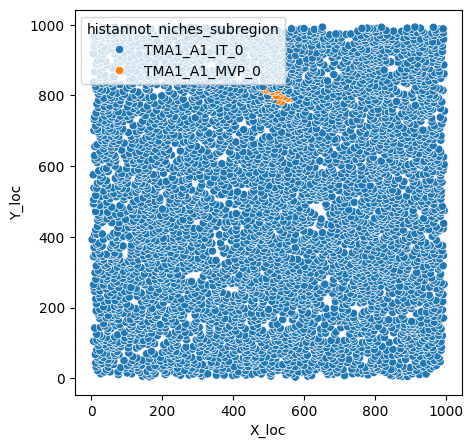

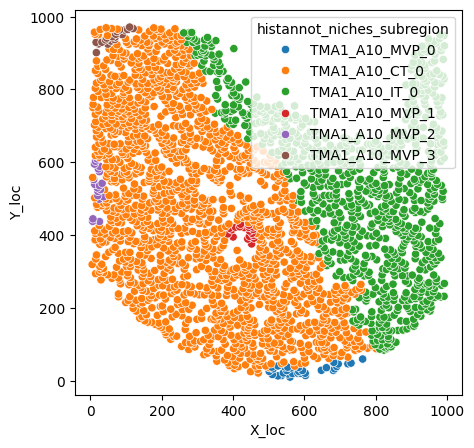

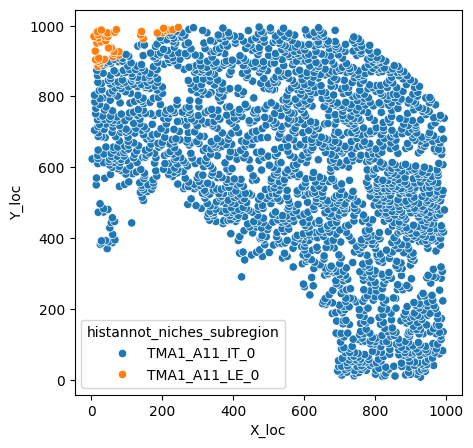

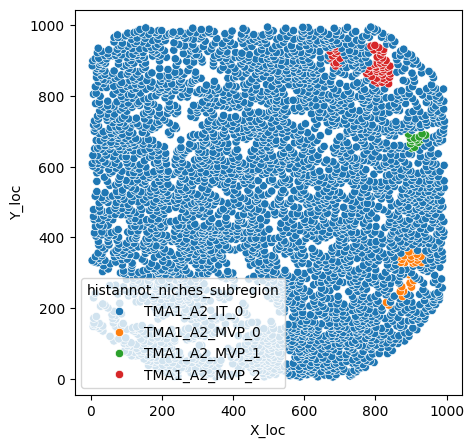

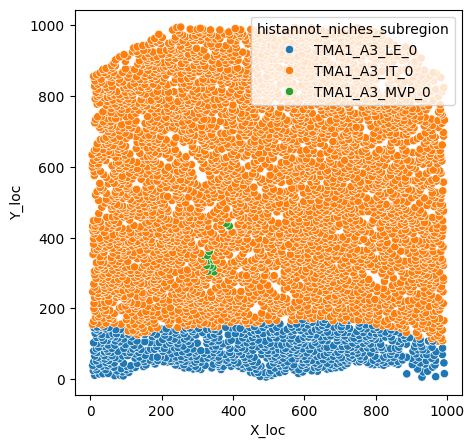

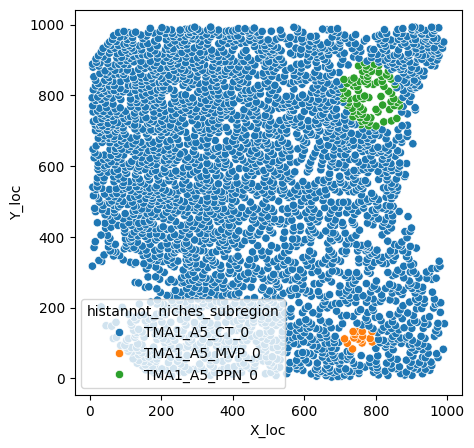

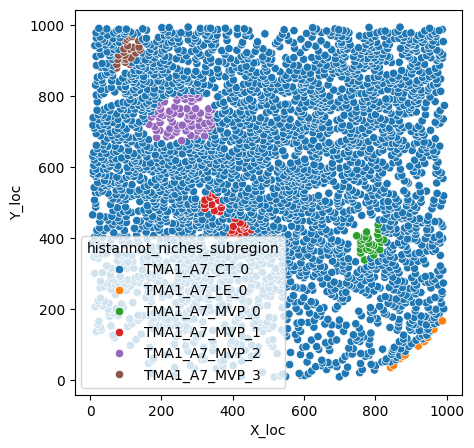

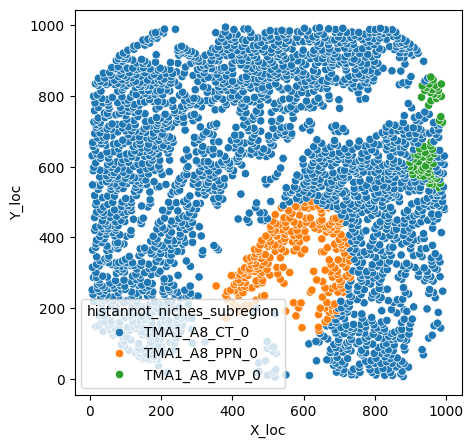

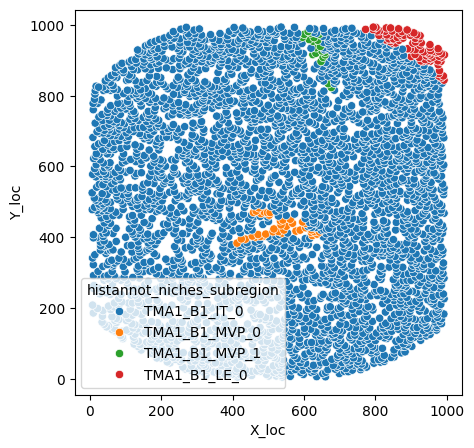

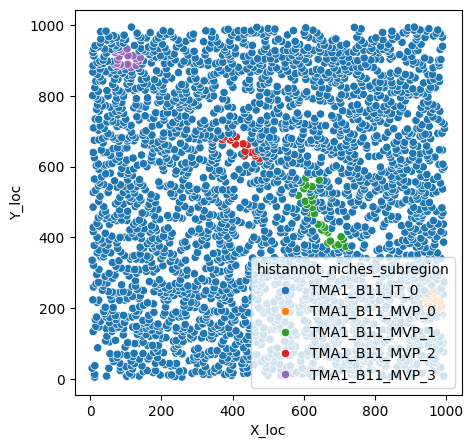

In [62]:
create_subregions(adata.obs, group_col='histannot_niches')

for r in adata.obs[~adata.obs['histannot_niches_subregion'].isna()].ROI.unique().tolist()[:10]:
    
    fig, ax = plt.subplots(figsize=(5,5))
    sb.scatterplot(adata.obs[adata.obs.ROI==r], x='X_loc', y='Y_loc', hue='histannot_niches_subregion', ax=ax)
    plt.show()

# Create AnnData from population data
Once we have identified subregions in our data, we can then summarise the anndata at this level, and create a new anndata object with the summarised data.
In the summarised anndata, each row is an individual subregion, and the variables are the number or proportion of cell types present

In [137]:
def create_population_anndata(adata, pop_obs, groupby=None, roi_obs='ROI', crosstab_normalize=False):
    '''
    adata: AnnData object
    pop_obs: Obs that identifies the population
    groupby: If supplied, Obs which identifies the level at which to summarise the populations, ie the subregion column. If None, populations will be summarised at the ROI level.
    roi_obs: Obs that identifies ROIs.
    crosstab_normalize: Whether to normalise counts. 'index' will normalise within each ROI/subregion, whereas 'columns' will normalise within each population.
    '''
    
    if groupby:
        pop_data = pd.crosstab([adata.obs[roi_obs], adata.obs[groupby]], adata.obs[pop_obs], normalize=crosstab_normalize)
        adata_pops = ad.AnnData(X=pop_data.values, obs=pop_data.reset_index()[[roi_obs, groupby]], var=pop_data.columns.tolist())
    else:
        pop_data = pd.crosstab(adata.obs[roi_obs], adata.obs[pop_obs], normalize=crosstab_normalize)
        adata_pops = ad.AnnData(X=pop_data.values, obs=pop_data.reset_index()[[roi_obs]], var=pop_data.columns.tolist())  
        
    adata_pops.var.set_index(0, inplace=True)
                       
    return adata_pops

In [138]:
adata_pops = create_population_anndata(adata, 
                                       pop_obs='population_final', 
                                       groupby='histannot_niches', 
                                       roi_obs='ROI', 
                                       crosstab_normalize='index')

We can now do clustering, PCA, and identify clusters in the ROI/subregions based upon the patterns of population abundance

In [139]:
sc.pp.log1p(adata_pops) #Log normalise as populations can vary a lot. Potentially not needed if you have not crosstab normalised above
sc.tl.pca(adata_pops, svd_solver="arpack")
sc.pp.neighbors(adata_pops, n_neighbors=10)
sc.tl.umap(adata_pops, min_dist=0.1, spread=1)
sc.tl.leiden(adata_pops, resolution=0.3)

computing PCA
    with n_comps=25
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using data matrix X directly
    computed neighbors (0:00:00)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP


  0%|          | 0/500 [00:00<?, ?it/s]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


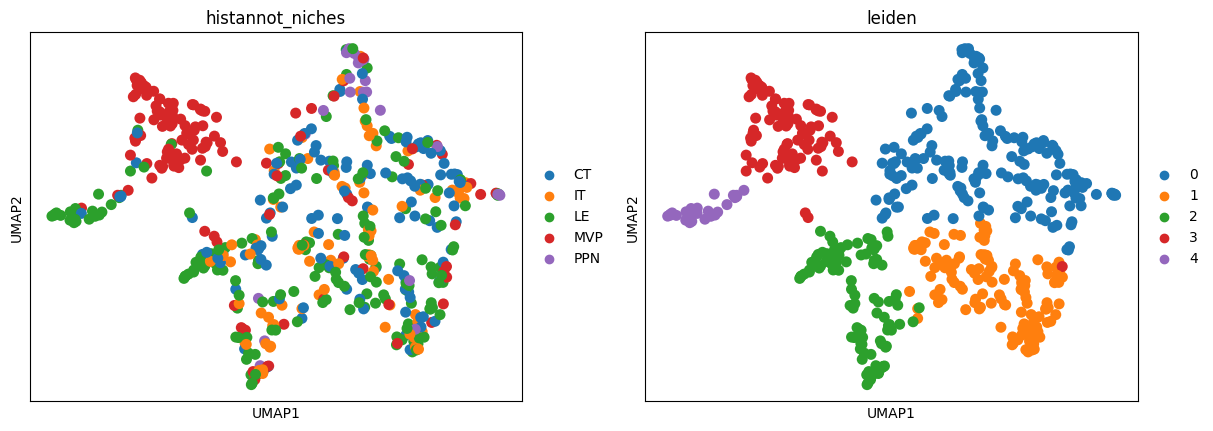

In [140]:
sc.pl.umap(adata_pops, color=['histannot_niches', 'leiden'], s=250)

We can now use a host of different plotting functions from Scanpy

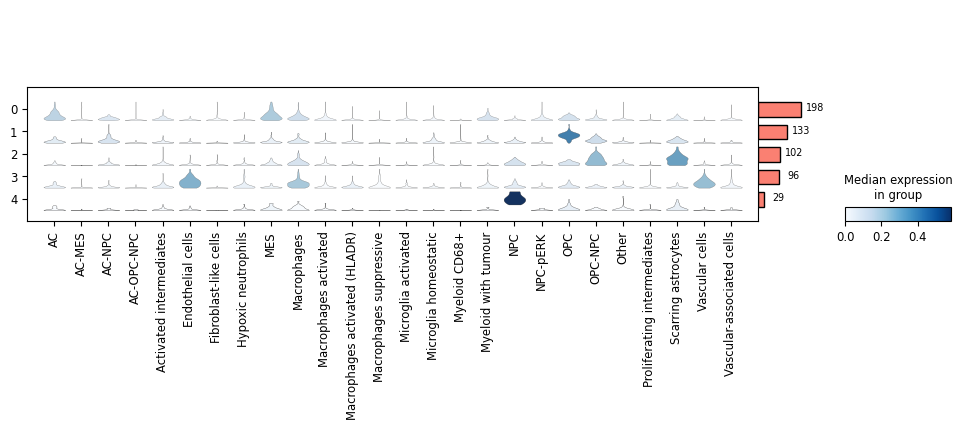

In [141]:
vp = sc.pl.stacked_violin(adata_pops, 
                          var_names=adata_pops.var_names, 
                          groupby='leiden', 
                          #standard_scale='obs', 
                          standard_scale='var',
                          return_fig=True)
vp.add_totals().style(ylim=(0,1.2)).show()

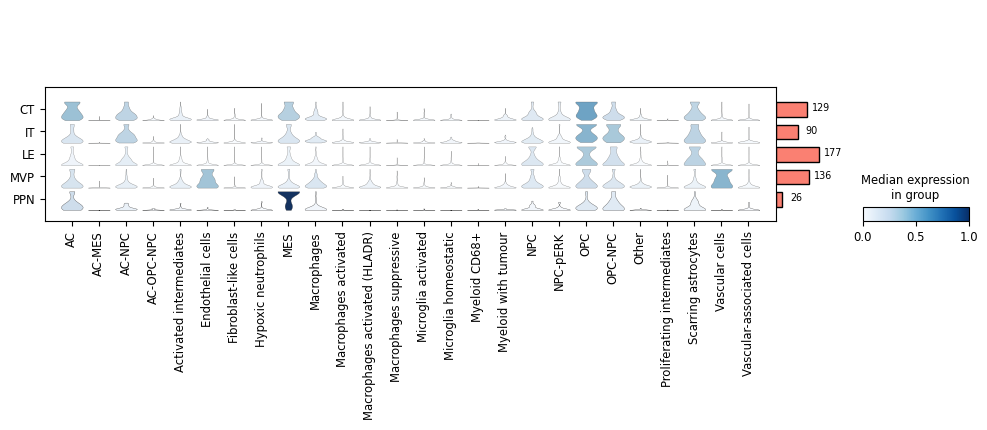

In [142]:
vp = sc.pl.stacked_violin(adata_pops, 
                          var_names=adata_pops.var_names, 
                          groupby='histannot_niches', 
                          standard_scale='obs', 
                          #standard_scale='var',
                          return_fig=True)

vp.add_totals().style(ylim=(0,1.2)).show()

# Overlayed heatmaps

In [109]:
def overlayed_heatmaps(dfs, cmaps=['Reds', 'Greens', 'Greens', 'Purples', 'Oranges', 'Greys'], mode='horizontal', vmin_list=None, vmax_list=None, figsize=(10, 10), grid_color='black', grid_linewidth=1, save_path=None, colorbar_plot_list=None, colorbar_params={'size': "2%", 'pad': 0.25, 'spacing': 0.25}, colorbar_labels=None, **heatmap_kwargs):
    """
    Overlays several heatmaps on the same plot, splitting each cell either horizontally into equal sections, or diagonally into two.
    Plots a heatmap for the first DataFrame in the list and overlays additional DataFrames either as horizontal bars or a diagonal split, with options to save and customize color bars.
    
    Parameters:
    - dfs: List of Pandas DataFrames to plot for 'horizontal' mode; exactly two for 'diagonal' mode. Dataframes must be the same size.
    - cmaps: List of colormaps for each DataFrame.
    - mode: 'horizontal' for horizontal bars; 'diagonal' for a diagonal split of the second DataFrame.
    - vmin_list: List of vmin values. Default is to calculate automatically.
    - vmax_list: List of vmax values. Default is to calculate automatically.
    - figsize: Tuple for the figure size.
    - grid_color: Color of the manually plotted grid lines.
    - grid_linewidth: Width of the manually plotted grid lines.
    - save_path: Path to save the output image. If None, the image is not saved.
    - colorbar_plot_list: By default all will be plotted, can alternatively provide a list of True/False entries to indicate which should be plotted
    - colorbar_params: Dictionary to customize the size and placement of colour bars (size, pad, spacing).
    - colorbar_labels: List of labels to associate with colorbars.
    - **heatmap_kwargs: Additional keyword arguments for sns.heatmap.
    """
    
    # Check all dataframes have the same shape
    assert all(d.shape == dfs[0].shape for d in dfs), 'Data frames are not all the same shape' 
    
    if mode == 'diagonal' and len(dfs) != 2:
        raise ValueError("Diagonal mode requires exactly two DataFrames.")
    if mode not in ['horizontal', 'diagonal']:
        raise ValueError("Mode must be either 'horizontal' or 'diagonal'.")
        
    # vmin and vmax lists haven't been supplied, then calculate them automatically
    if not vmin_list:
        vmin_list = [df.min().min() for df in dfs]
    if not vmax_list:
        vmax_list = [df.max().max() for df in dfs]
        
    if not colorbar_plot_list:
        colorbar_plot_list = [True for x in range(len(dfs))]
        

    fig, ax = plt.subplots(figsize=figsize)

    # Plot the first heatmap as the base
    sns.heatmap(dfs[0], cmap=cmaps[0], cbar=False, ax=ax, **heatmap_kwargs)

    mappables = [ScalarMappable(Normalize(vmin=vmin_list[0], vmax=vmax_list[0]), cmap=cmaps[0])]
    
    if mode == 'horizontal':
        cell_height = 1.0 / len(dfs)
        for idx, df in enumerate(dfs[1:], start=1):
            norm = Normalize(vmin=vmin_list[idx], vmax=vmax_list[idx])
            mappable = ScalarMappable(norm=norm, cmap=cmaps[idx])
            mappables.append(mappable)

            for i in range(df.shape[0]):
                for j in range(df.shape[1]):
                    bottom = i + cell_height * (len(dfs) - idx - 1)
                    rect = plt.Rectangle((j, bottom), 1, cell_height, color=mappable.to_rgba(df.iloc[i, j]))
                    ax.add_patch(rect)
    elif mode == 'diagonal':
        df = dfs[1]
        norm = Normalize(vmin=vmin_list[1], vmax=vmax_list[1])
        mappable = ScalarMappable(norm=norm, cmap=cmaps[1])
        mappables.append(mappable)

        for i in range(df.shape[0]):
            for j in range(df.shape[1]):
                triangle = plt.Polygon([(j, i), (j+1, i), (j, i+1)], color=mappable.to_rgba(df.iloc[i, j]))
                ax.add_patch(triangle)

    # Manually plot grid lines
    for i in range(dfs[0].shape[0] + 1):
        ax.axhline(i, color=grid_color, linewidth=grid_linewidth)
    for j in range(dfs[0].shape[1] + 1):
        ax.axvline(j, color=grid_color, linewidth=grid_linewidth)

    ax.set_xlim([0, dfs[0].shape[1]])
    ax.set_ylim([0, dfs[0].shape[0]])

    # Create color bars
    divider = make_axes_locatable(ax)
    for idx, mappable in enumerate(mappables, start=0):
        
        # By default all will be plotted, but can alternatively only plot some
        if colorbar_plot_list[idx]:
            cax = divider.append_axes("right", size=colorbar_params.get('size', "2%"), pad=colorbar_params.get('pad', 0.02) + colorbar_params.get('spacing', 0.1) * idx)
            plt.colorbar(mappable, cax=cax)

            if colorbar_labels:
                cax.set_ylabel(colorbar_labels[idx])

    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()


### Example usages

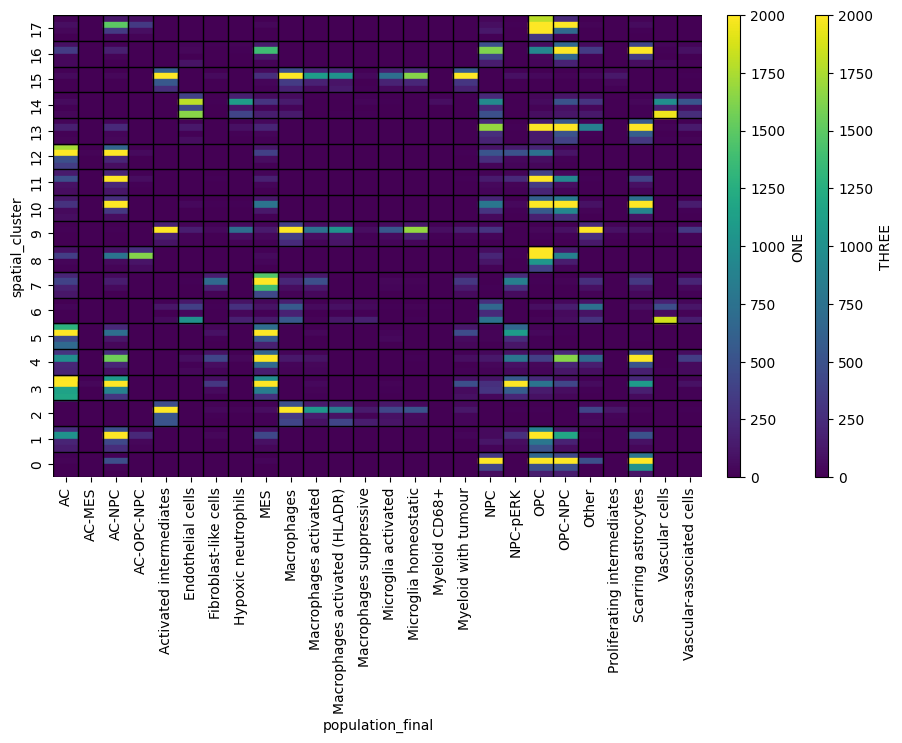

In [115]:
# Example usage
data1 = pd.crosstab(adata.obs['histannot_niches'], adata.obs['population_final'], normalize='index')
data2 = pd.crosstab(adata.obs['histannot_niches'], adata.obs['population_final'], normalize='columns')
data3 = pd.crosstab(adata.obs['histannot_niches'], adata.obs['population_final'])

pop_data = pd.crosstab([adata.obs['histannot_niches'], adata.obs['spatial_cluster']], adata.obs['population_final'])

overlayed_heatmaps([pop_data.loc[x,:] for x in ['CT','IT','LE','MVP']], 
                       cmaps=['viridis', 'viridis', 'viridis', 'viridis'], 
                       colorbar_labels=['ONE','TWO','THREE','FOUR'], 
                       colorbar_plot_list=[True,False,True,False],
                       mode='horizontal',
                       vmax_list=[2000, 2000, 2000, 2000],
                       figsize=(10, 6), 
                       grid_color='black', 
                       grid_linewidth=1
                       )


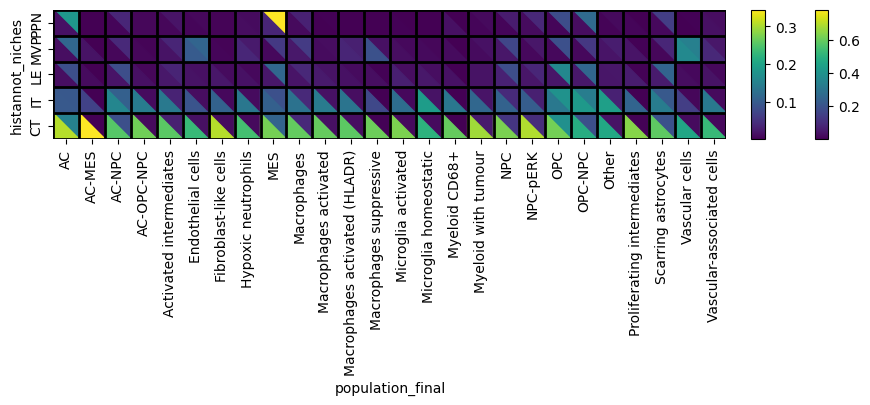

In [116]:
overlayed_heatmaps([data1, data2],
                   cmaps=['viridis', 'viridis'],
                   figsize=(10, 6),
                   grid_color='black',
                   grid_linewidth=2,
                   mode='diagonal',
                   square=True)

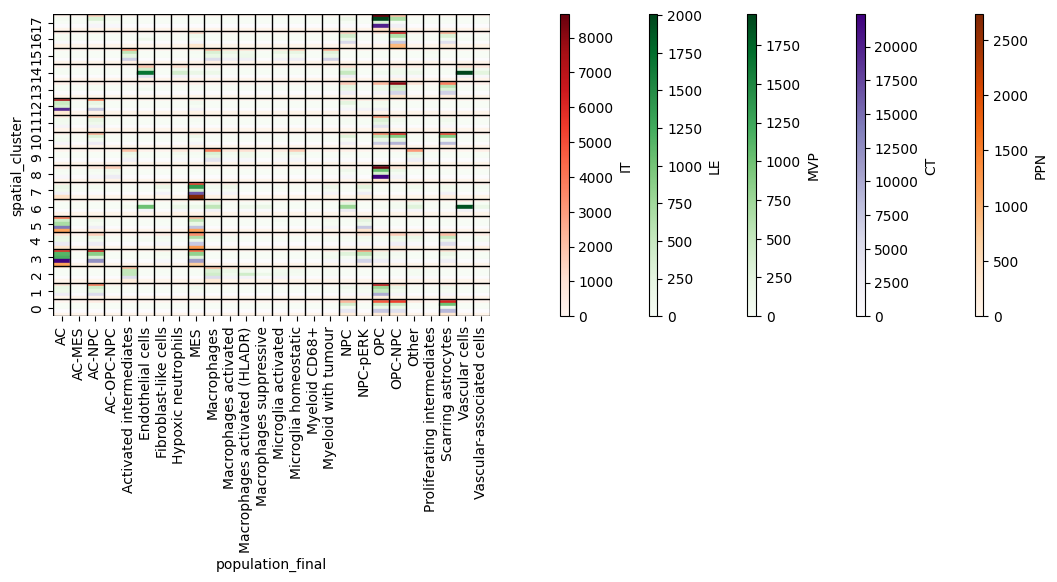

In [121]:
factor = 'histannot_niches'

factor_list = adata.obs[factor].unique().dropna().tolist()

pop_data = pd.crosstab([adata.obs[factor], adata.obs['spatial_cluster']], adata.obs['population_final'])

overlayed_heatmaps([pop_data.loc[x] for x in factor_list], figsize=(12, 12), 
                   colorbar_labels=factor_list,
                   grid_color='black', 
                   grid_linewidth=1, 
                   mode='horizontal', 
                   colorbar_params={'size': "2%", 'pad': 0.7, 'spacing': 0.1},
                   square=True)

# Squidpy interactions by subregion

In [171]:
def squidpy_subregion_interactions(adata,
                                   population_obs,
                                   subregion,
                                   radius=(0,20),
                                   n_permutations=1000):

    # If unique subregions haven't already been calculated, then do it now
    if f'{subregion}_subregion' not in adata.obs:
        create_subregions(adata.obs, group_col='histannot_niches')
    else:
        print(f'{subregion}_subregion found in AnnData.obs - assuming subregions already calculated')

    subregion_list = adata.obs[subregion].unique().dropna().tolist()

    # Setup empty dicts to capture results
    results = {}
    results['count'], results['zscore'] = {}, {}

    for s in subregion_list:

        print(f'Calculating for {s}...')
        
        # Remove cells which were not in a subregion
        adata_sub = adata[~adata.obs[f'{subregion}_subregion'].isna()].copy()

        # Only look at specific subregion
        adata_sub = adata_sub[adata_sub.obs[subregion]==s]

        # Make sure they are categorical
        adata_sub.obs[f'{subregion}_subregion'] = adata_sub.obs[f'{subregion}_subregion'].astype('category')

        sq.gr.spatial_neighbors(adata_sub, library_key=f'{subregion}_subregion', coord_type='generic', radius=radius)
        sq.gr.nhood_enrichment(adata_sub, cluster_key=population_obs, n_perms=n_permutations)

        results[str(s)] = adata_sub.uns[f'{population_obs}_nhood_enrichment'].copy()

        pops = pd.Categorical(adata_sub.obs[population_obs].cat.categories)

        for x in ['zscore','count']:

            array = adata_sub.uns[f'{population_obs}_nhood_enrichment'][x]
            df = pd.DataFrame(data = array, index = pops, columns=pops, dtype=array.dtype)

            results[x][s] = df.copy()
            
    return results

def plot_subregion_interactions(interactions_results, log_counts=True, figsize=(10, 10), cmap='viridis', **heatmap_kwargs):
    
    # Get sublists from results structure
    subregion_list = list(interactions_results['count'].keys())
    
    # Log counts
    if log_counts:
        count_dfs = [np.log1p(interactions_results['count'][x]) for x in subregion_list]
    else:
        count_dfs = [interactions_results['count'][x] for x in subregion_list]

    zscore_dfs = [interactions_results['zscore'][x] for x in subregion_list]
    
    plot_advanced_heatmaps(count_dfs, 
                       cmaps=[cmap for x in range(len(subregion_list))], 
                       figsize=figsize, 
                       save_path='subregions_counts.svg',
                        **heatmap_kwargs)
    
    plot_advanced_heatmaps(zscore_dfs, 
                       cmaps=[cmap for x in range(len(subregion_list))], 
                       figsize=figsize, 
                       grid_color='black', 
                       save_path='subregions_zscore.svg',
                        **heatmap_kwargs)

### Example usage

In [149]:
adata = ad.read_h5ad('adata.h5ad')

interactions_results = squidpy_subregion_interactions(adata,
                                   population_obs='population_final',
                                   subregion='histannot_niches',
                                   radius=(0,20),
                                   n_permutations=1000)

Columns added to adata.obs: histannot_niches_subregion, histannot_niches_subregion_cluster
Calculating for IT...
Creating graph using `generic` coordinates and `None` transform and `94` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:10)
Calculating neighborhood enrichment using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['population_final_nhood_enrichment']`
Finish (0:01:06)
Calculating for LE...
Creating graph using `generic` coordinates and `None` transform and `204` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:07)
Calculating neighborhood enrichment using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['population_final_nhood_enrichment']`
Finish (0:00:11)
Calculating for MVP...
Creating graph using `generic` coordinates and `None` transform and `460` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:14)
Calculating neighborhood enrichment using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['population_final_nhood_enrichment']`
Finish (0:00:10)
Calculating for CT...
Creating graph using `generic` coordinates and `None` transform and `137` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:21)
Calculating neighborhood enrichment using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['population_final_nhood_enrichment']`
Finish (0:00:45)
Calculating for PPN...
Creating graph using `generic` coordinates and `None` transform and `34` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:01)
Calculating neighborhood enrichment using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['population_final_nhood_enrichment']`
Finish (0:00:10)


C:\Anaconda3\envs\spatial\lib\site-packages\squidpy\gr\_nhood.py:182: RuntimeWarning: divide by zero encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


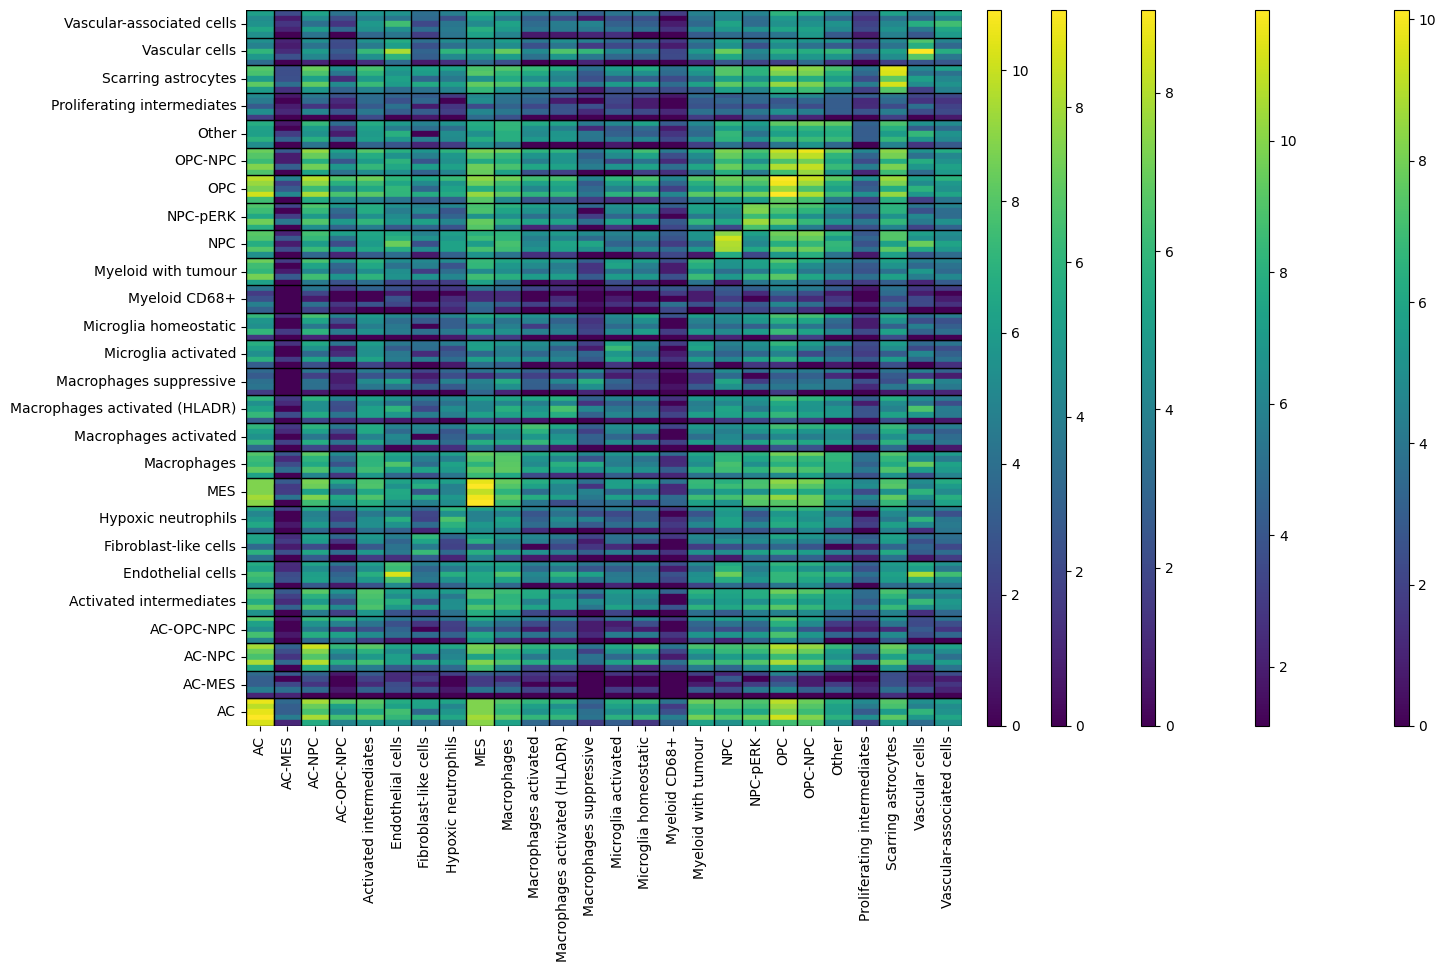

C:\Anaconda3\envs\spatial\lib\site-packages\matplotlib\colors.py:1371: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


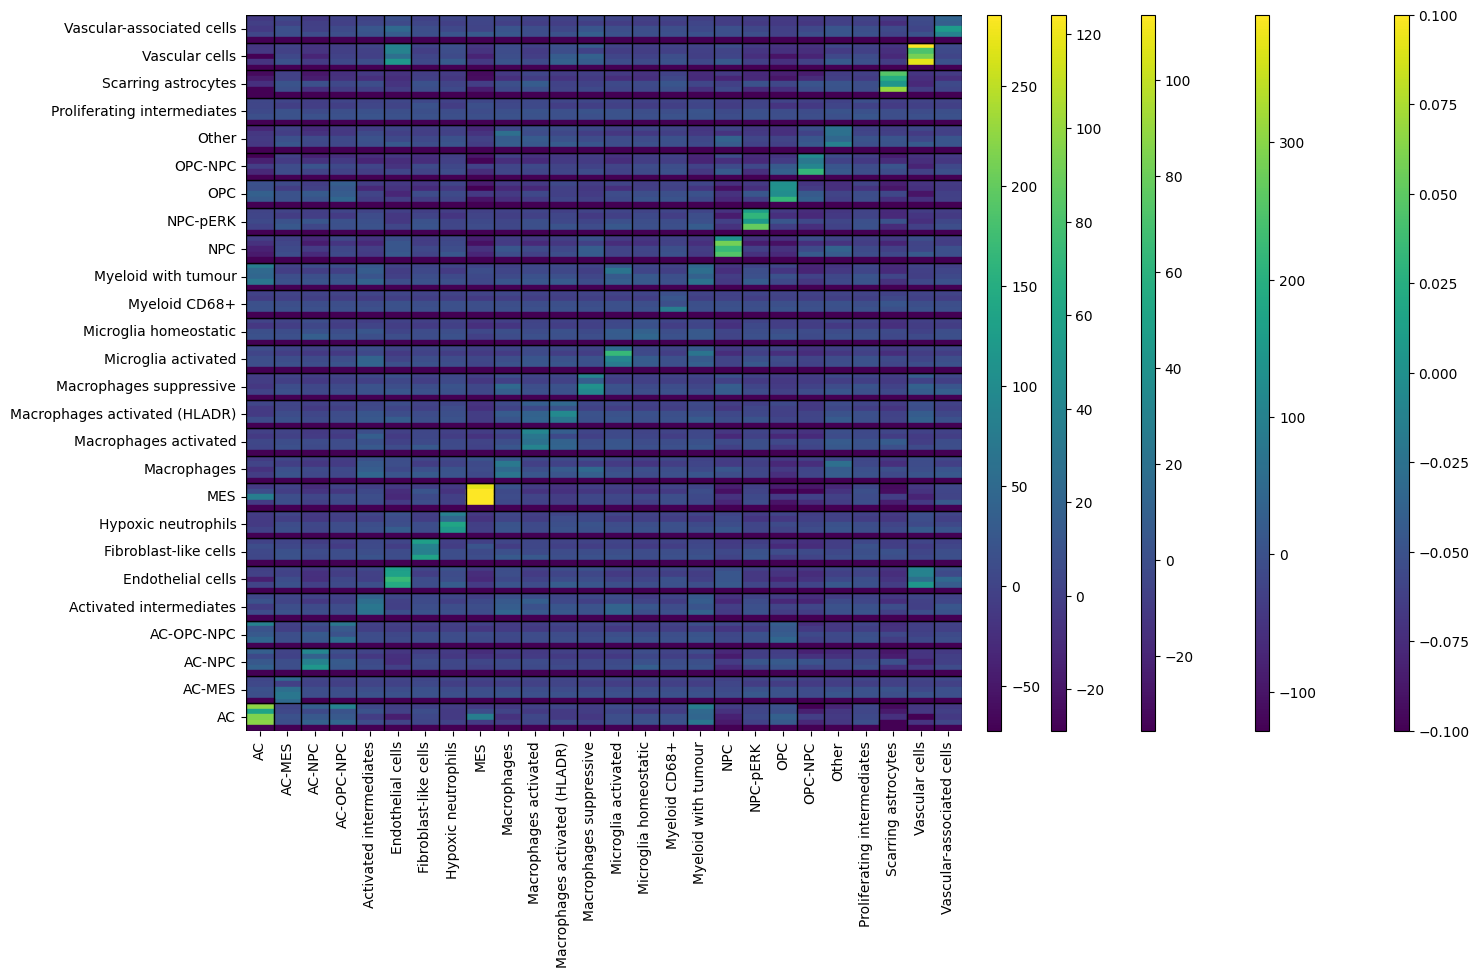

In [172]:
plot_subregion_interactions(interactions_results, 
                            log_counts=True, 
                            figsize=(15, 15), 
                            cmap='viridis', 
                            square=True)